In [1]:
# # Please uncomment the following line of code to install MedMNIST which is the library
# # which stores the data and makes the train/test split.

# !pip install medmnist

# # The following line installs the keras tuner for hyperparameter tuning.
# !pip install -q -U keras-tuner

In [2]:
# General Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import cv2
import pandas as pd
import time

# Tensorflow Imports
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models, losses
from keras.datasets import fashion_mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer, Conv2D, Conv2DTranspose
from keras.preprocessing.image import ImageDataGenerator
from keras import utils
from tensorflow.keras import backend
import keras_tuner as kt


# Scikit-Image Imports
import skimage
from skimage import io
from skimage.transform import radon, rescale
from skimage.transform import iradon
from skimage.transform.radon_transform import _get_fourier_filter

# Scikit-Learn Imports
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Medical MNIST Dataset
import medmnist
from medmnist import INFO, Evaluator
print(medmnist.__version__)

2.0.2


## Generating The Simulated Data

In [3]:
def circular_mask(radius, im):
    '''
    This function creates a circular mask for the image. The returned image is going to be grayscale.
    :param radius: The radius of the circular mask to be applied (in pixels).
    :param im: The array corresponding to image that needs to be masked.
    :return masked_data: An array of the same shape as the input image array with the mask applied.
    '''
    height,width = im.shape
    circle_img = np.zeros((height,width), np.uint8)
    cv2.circle(circle_img,(int(width/2),int(height/2)),radius,(255,0,0),thickness=-1)
    masked_data = cv2.bitwise_and(im, im, mask=circle_img)
    
    return masked_data

In [4]:
def radon_transform(image, mask_radius=14, n_slices=28):
    '''
    Applies a circular mask to an image and applies the radon transform to the
    truncated image.
    :param image: Image array cooresponding to the target image.
    :param mask_radius: The radius of the circular mask (in pixels).
    :param n_slices: The number of slices that the radon transform is calculated
    over.
    :return sinogram: The array corresponsing to the sinogram (radon trasnform)
    representation of the input image.
    '''
    
    center_row, center_col = int(image.shape[0]/2), int(image.shape[1]/2)
    image = circular_mask(mask_radius, image)
    image = image[center_row-mask_radius:center_row+mask_radius,
                  center_col-mask_radius:center_col+mask_radius]
    
    theta = np.linspace(0., 180., n_slices, endpoint=False)
    sinogram = radon(image, theta=theta)
    
    return sinogram


## Exploratory Data Analysis

In [5]:
data_flag = 'organcmnist'
data_info = INFO[data_flag]
DataClass = getattr(medmnist, data_info['python_class'])

# train_dataset = DataClass(split='train', download=True)
# test_dataset = DataClass(split='test', download=True)

train_dataset = DataClass(split='train', download=False).imgs
test_dataset = DataClass(split='test', download=False).imgs

In [6]:
train_dataset.shape

(13000, 28, 28)

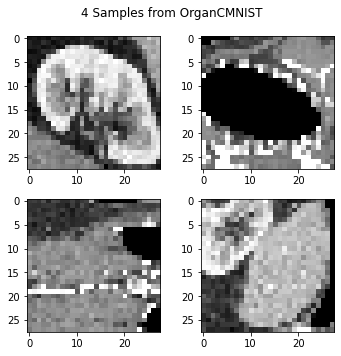

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
for j in range(len(train_dataset[:4])):
#     radon_img = radon_transform(trainX[j], n_slices=trainX.shape[1])
#     trainXradon[j] = cv2.normalize(radon_img, None, alpha=0, beta=255,
#                              norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    plt.subplot(220 + 1 + j)
    plt.imshow(train_dataset[j], cmap='gray')
#     plt.colorbar();
fig.suptitle('4 Samples from OrganCMNIST')
plt.tight_layout();
# plt.show()

In [8]:
trainXradon = np.empty_like(train_dataset)
testXradon = np.empty_like(test_dataset)

trainXfloat = np.empty_like(train_dataset)
testXfloat = np.empty_like(test_dataset)

print('Train: X=%s, y=%s' % (trainXradon.shape, trainXfloat.shape))
print('Test: X=%s, y=%s' % (testXradon.shape, testXfloat.shape))

Train: X=(13000, 28, 28), y=(13000, 28, 28)
Test: X=(8268, 28, 28), y=(8268, 28, 28)


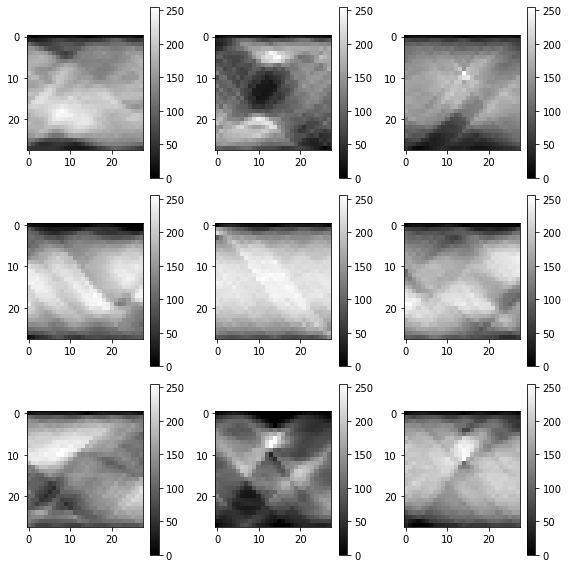

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
for j in range(len(trainXfloat[:9])):
    radon_img = radon_transform(train_dataset[j], n_slices=train_dataset.shape[1])
    trainXradon[j] = cv2.normalize(radon_img, None, alpha=0, beta=255,
                             norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    plt.subplot(330 + 1 + j)
    plt.imshow(trainXradon[j], cmap='gray')
    plt.colorbar();
    plt.tight_layout();
plt.show()

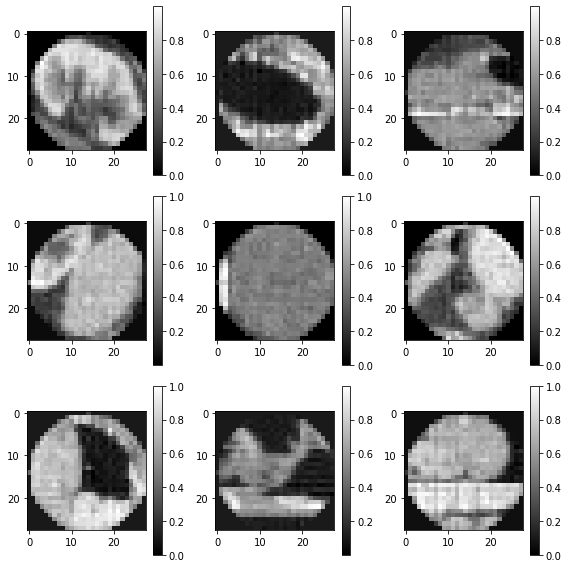

In [10]:
theta = np.linspace(0., 180., trainXradon.shape[1], endpoint=False)

fig, ax = plt.subplots(figsize=(8, 8))
for j in range(len(trainXradon[:9])):
    sinogram = trainXradon[j]
    plt.subplot(330 + 1 + j)
    inv_rad = iradon(sinogram, theta, filter_name='ramp')
    inv_rad = cv2.normalize(inv_rad, None, alpha=0, beta=1,
                             norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    plt.imshow(inv_rad, cmap='gray')
    plt.colorbar();
    plt.tight_layout();
plt.show()

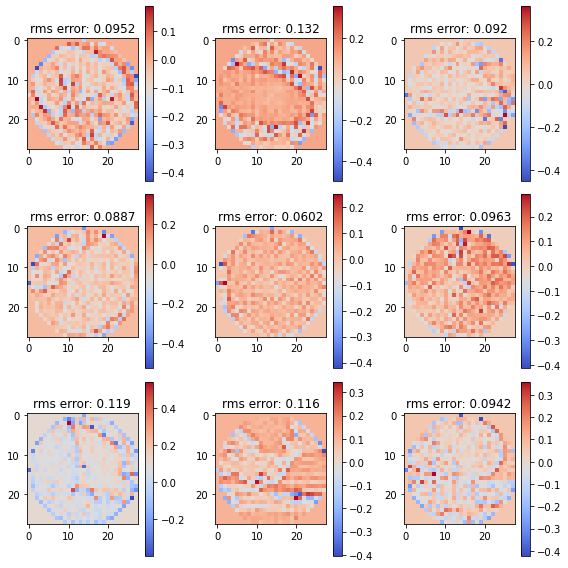

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
for j in range(len(trainXfloat[:9])):
    reconstruction = iradon(trainXradon[j], theta, filter_name='ramp')
    reconstruction = cv2.normalize(reconstruction, None, alpha=0, beta=1,
                             norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    original = circular_mask(14, train_dataset[j])
    original = cv2.normalize(original, None, alpha=0, beta=1,
                             norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    error = reconstruction - original
    plt.subplot(330 + 1 + j)
    plt.imshow(error, cmap='coolwarm')
    plt.title(f'rms error: {np.sqrt(np.mean(error**2)):.3g}')
    plt.colorbar();
    plt.tight_layout();
plt.show()

Clearly, the quality of the reconstruction is lacking the reconstruction is also quite noisy. Now that we have a proof of concept, we'll go ahead and create our training dataset.

# Making the Actual Train/Test Datasets

In [12]:
data_flag = 'organamnist'
data_info = INFO[data_flag]
DataClass = getattr(medmnist, data_info['python_class'])

# # Please uncomment the following lines to download the data.
# train_dataset = DataClass(split='train', download=True)
# test_dataset = DataClass(split='test', download=True)

# Organ-A-MNIST
train_dataset_a = DataClass(split='train', download=False).imgs
test_dataset_a = DataClass(split='test', download=False).imgs

# Reshaping the train-test split to ~83% train and 17% test.
train_dataset = np.concatenate((train_dataset_a,
                                test_dataset_a[:int(len(test_dataset_a)/2)]))

test_dataset = test_dataset_a[int(len(test_dataset_a)/2):]

trainXradon = np.empty_like(train_dataset, dtype='float')
testXradon = np.empty_like(test_dataset, dtype='float')

trainXfloat = np.empty_like(train_dataset, dtype='float')
testXfloat = np.empty_like(test_dataset, dtype='float')

print('Train: X=%s, y=%s' % (train_dataset.shape, train_dataset.shape))
print('Test: X=%s, y=%s' % (test_dataset.shape, test_dataset.shape))

print('Train: X=%s, y=%s' % (train_dataset.shape, train_dataset.shape))
print('Test: X=%s, y=%s' % (test_dataset.shape, test_dataset.shape))

Train: X=(43470, 28, 28), y=(43470, 28, 28)
Test: X=(8889, 28, 28), y=(8889, 28, 28)
Train: X=(43470, 28, 28), y=(43470, 28, 28)
Test: X=(8889, 28, 28), y=(8889, 28, 28)


In [13]:
# # Generate the Train Dataset (trainXradon -> X, and trainXfloat -> y)
for j in range(len(train_dataset)):
    
    # # Making the trainXfloat dataset
    trainXfloat[j] = train_dataset[j]
    trainXfloat[j] = circular_mask(14, train_dataset[j])
    # # Applying Histogram Equalization
    trainXfloat[j] = skimage.exposure.equalize_hist(trainXfloat[j])
    
    # # Making the trainXradon dataset
    trainXradon[j] = radon_transform(train_dataset[j], n_slices=train_dataset.shape[1])
    # # Applying Histogram Equalization
    trainXradon[j] = skimage.exposure.equalize_hist(trainXradon[j])


# # Generate the Test Dataset (testXradon -> X, and testXfloat -> y)
for k in range(len(test_dataset)):
    
    # # Making the testXfloat dataset
    testXfloat[k] = test_dataset[k]
    testXfloat[k] = circular_mask(14, test_dataset[k])
    # # Applying Histogram Equalization
    testXfloat[k] = skimage.exposure.equalize_hist(testXfloat[k])
    
    # # Making the testXradon dataset
    testXradon[k] = radon_transform(test_dataset[k], n_slices=test_dataset.shape[1])
    # # Applying Histogram Equalization
    testXradon[k] = skimage.exposure.equalize_hist(testXradon[k])

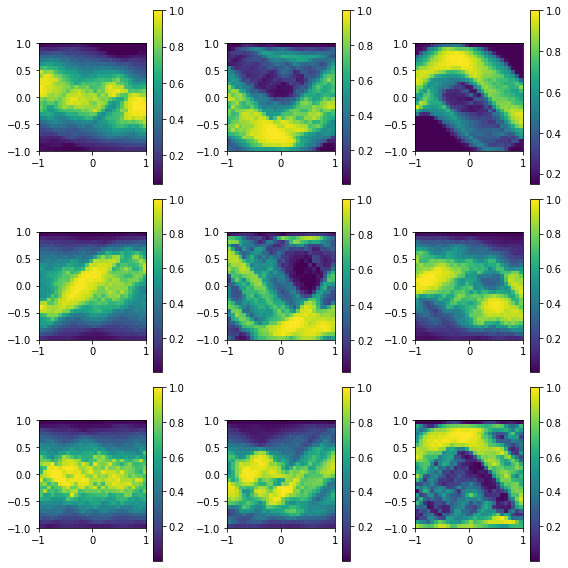

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
for j in range(len(trainXradon[:9])):
    plt.subplot(330 + 1 + j)
    plt.imshow(trainXradon[20+j], extent=[-1, 1, -1, 1])
    plt.colorbar();
    plt.tight_layout();

## Setting Up and Training the Model

In [15]:
# The Million-Param-Model Architecture

class CNN(Model):
    def __init__(self):
        super(CNN, self).__init__()
        self.CNN = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(54, (2, 2), activation='relu', padding='same', strides=1),
            layers.Conv2D(28, (2, 2), activation='relu', padding='same', strides=1),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(784, activation='sigmoid'),
            layers.ReLU(),
            layers.Reshape((28, 28))
        ])

    def call(self, x):
        result = self.CNN(x)
        return result

reconstructor = CNN()

In [16]:
reconstructor.compile(optimizer='adam', loss=losses.MeanSquaredError(),
                      metrics=['mse'])

In [17]:
reconstructor.CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 54)        270       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 28)        6076      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 28)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5488)              0         
                                                                 
 dense (Dense)               (None, 784)               4303376   
                                                                 
 re_lu (ReLU)                (None, 784)               0         
                                                        

In [18]:
# # Line is uncommented to load the weights from previous training runs.
reconstructor.load_weights('./checkpoints/Million-Param-Model-OrganAMNIST')

In [19]:
# # Assign the epochs here if training
epochs_ = None

# reconstructor.fit(trainXradon, trainXfloat,
#                 epochs=epochs_,
#                 validation_data=(testXradon, testXfloat))

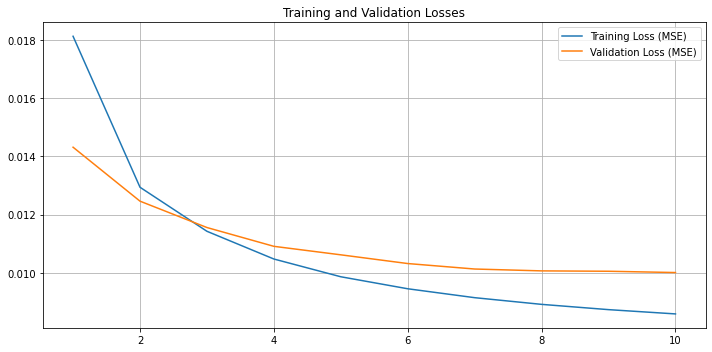

In [20]:
# Check if variable epochs is declared. If not, model was not fitted in this run.
if epochs_:
    epochs_range = range(1, epochs_+1)
    # Training/Validation values from this run.
    train_hist = reconstructor.history.history
else:
    epochs_range = range(1, 11)
    # Training/Validation values from last run of 10 epochs.
    train_hist = {'loss': 
                 [0.01811813749372959,
                  0.012936720624566078,
                  0.01142553985118866,
                  0.01047421433031559,
                  0.009864970110356808,
                  0.009452932514250278,
                  0.00914724264293909,
                  0.008917714469134808,
                  0.008736778981983662,
                  0.008589865639805794],
                  'val_loss': 
                 [0.01431080512702465,
                  0.012459293939173222,
                  0.011554657481610775,
                  0.01090945303440094,
                  0.010617827996611595,
                  0.010318589396774769,
                  0.010130584239959717,
                  0.010066872462630272,
                  0.010053767822682858,
                  0.010009846650063992]}

    
loss = train_hist['loss']
val_loss = train_hist['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, loss, label='Training Loss (MSE)')
plt.plot(epochs_range, val_loss, label='Validation Loss (MSE)')
plt.legend()
plt.title('Training and Validation Losses');
plt.grid()
plt.tight_layout();

In [21]:
# # Line is uncommented if pre-trained weights are loaded.
scores = reconstructor.evaluate(testXradon, testXfloat, verbose=0)
print("%s: %f" % (reconstructor.metrics_names[0], scores[0]))

2022-04-30 21:45:28.058607: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


loss: 0.010010


In [22]:
# # Line is uncommented if the current loss is less than previous runs.
# reconstructor.save_weights('./checkpoints/Million-Param-Model-OrganAMNIST')

## Evaluating the NN vs. FBP Reconstructions

In [23]:
theta = np.linspace(0., 180., trainXradon.shape[1], endpoint=False)

iradon_recons = np.empty_like(testXradon, dtype='float')
iradon_time = 0

nn_recons = np.empty_like(testXradon, dtype='float')
nn_time = 0

start_iradon = time.time()
for i in range(len(testXradon)):
    iradon_recons[i] = iradon(testXradon[i], theta, filter_name='ramp')
end_iradon = time.time()
iradon_time = end_iradon - start_iradon

start_nn = time.time()
nn_recons = reconstructor.CNN(testXradon).numpy()
end_nn = time.time()
nn_time = end_nn-start_nn

In [24]:
print('The time required to generate the Inverse Radon Reconstructions: ', iradon_time)
print('The time required to generate the Neural Network Reconstructions: ', nn_time)

The time required to generate the Inverse Radon Reconstructions:  3.887335777282715
The time required to generate the Neural Network Reconstructions:  1.3741750717163086


In [25]:
iradon_mse_vals = []
nn_mse_vals = []

for i in range(testXfloat.shape[0]):
    iradon_mse_vals.append(np.sqrt(((iradon(testXradon[i], theta, filter_name='ramp') - testXfloat[i]) ** 2).mean()))

for i in range(testXfloat.shape[0]):
    nn_mse_vals.append(np.sqrt(((nn_recons[i] - testXfloat[i]) ** 2).mean()))
    
    
print('The avgerage MSE for iRadon Reconstruction is: ', sum(iradon_mse_vals)/testXfloat.shape[0])
print('The avgerage MSE for Neural Network Reconstruction is: ', sum(nn_mse_vals)/testXfloat.shape[0])

The avgerage MSE for iRadon Reconstruction is:  0.6001481189071889
The avgerage MSE for Neural Network Reconstruction is:  0.09722634089292898


In [26]:
print('Meaning, the Neural Network has an MSE that is: ', sum(iradon_mse_vals)/sum(nn_mse_vals),'times smaller than that of FBP, and')
print('the Neural Network is: ', iradon_time/nn_time,'times faster than FBP.')

Meaning, the Neural Network has an MSE that is:  6.172690583595089 times smaller than that of FBP, and
the Neural Network is:  2.82885045529718 times faster than FBP.


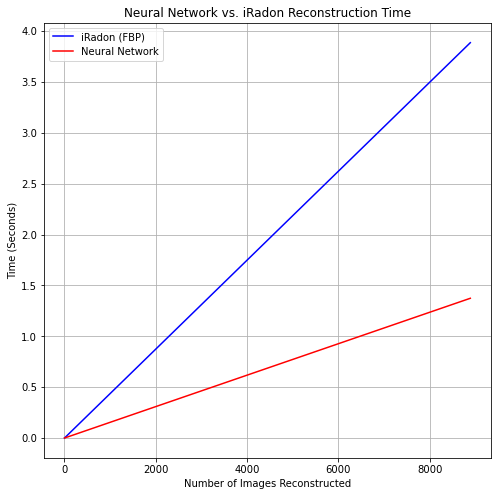

In [27]:
nn_times_list = [i*(nn_time/len(testXfloat)) for i in range(len(testXfloat))]
iradon_times_list = [i*(iradon_time/len(testXfloat)) for i in range(len(testXfloat))]

plt.figure(figsize=(8, 8))
plt.plot(range(len(testXfloat)), iradon_times_list, 'blue', label='iRadon (FBP)')
plt.plot(range(len(testXfloat)), nn_times_list, 'red', label='Neural Network')
plt.title('Neural Network vs. iRadon Reconstruction Time')
plt.xlabel('Number of Images Reconstructed')
plt.ylabel('Time (Seconds)')
plt.grid()
plt.legend();

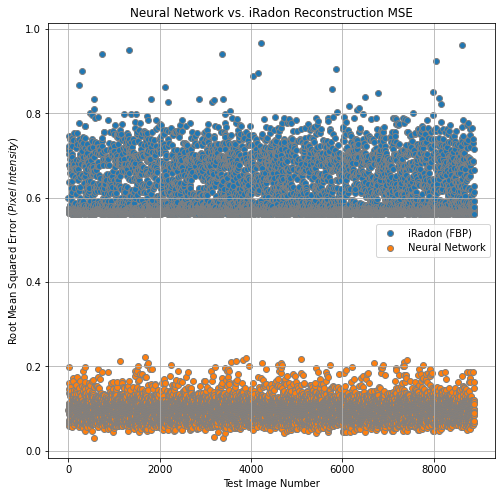

In [28]:
plt.figure(figsize=(8, 8))
plt.scatter(range(len(testXfloat)), iradon_mse_vals, edgecolors= 'gray', label='iRadon (FBP)')
plt.scatter(range(len(testXfloat)), nn_mse_vals, edgecolors= 'gray', label='Neural Network')
plt.title('Neural Network vs. iRadon Reconstruction MSE')
plt.xlabel('Test Image Number')
plt.ylabel('Root Mean Squared Error ($Pixel$ $Intensity$)')
plt.grid()
plt.legend();

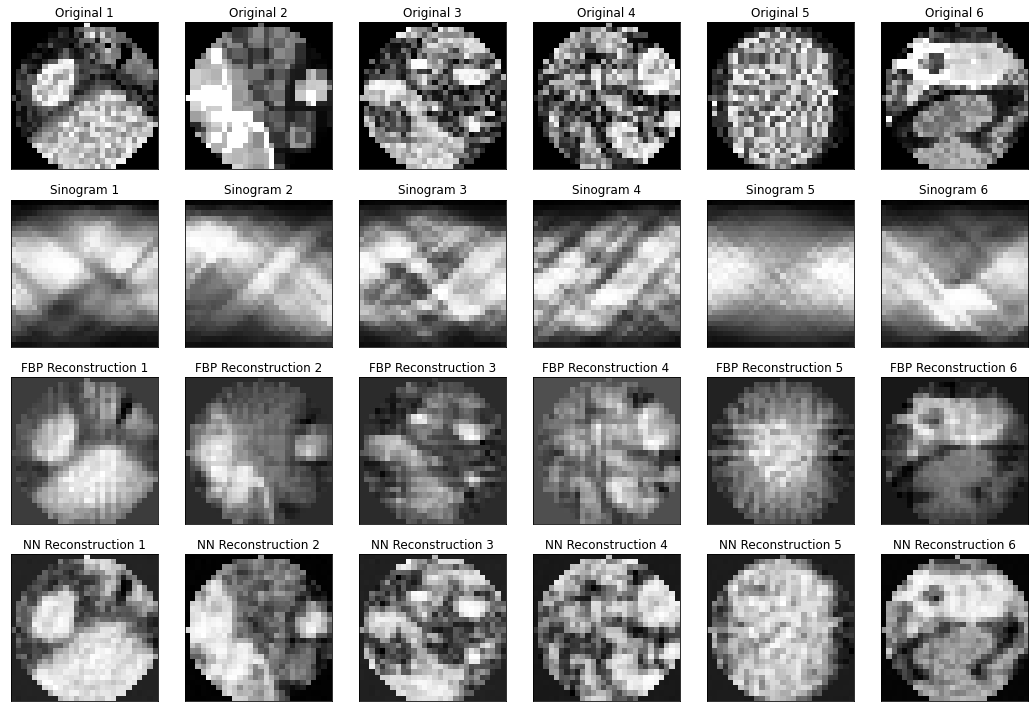

In [29]:
n = 6
theta = np.linspace(0., 180., trainXradon.shape[1], endpoint=False)

plt.figure(figsize=(15, 10))
for i in range(n):
    
    
    offset = 258
    
    # display original
    cx = plt.subplot(4, n, i + 1)
    plt.title("Original " + str(i+1))
    plt.imshow(testXfloat[offset+i])
    plt.gray()
    cx.get_xaxis().set_visible(False)
    cx.get_yaxis().set_visible(False)
    
    # display sinogram
    ax = plt.subplot(4, n, i + n + 1)
    plt.title("Sinogram "+ str(i+1))
    plt.imshow(testXradon[offset+i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display iRadon (FBP) reconstruction
    cx = plt.subplot(4, n, i + 2*n + 1)
    plt.title("FBP Reconstruction "+ str(i+1))
    recon = iradon(testXradon[offset+i], theta, filter_name='ramp')
    plt.imshow(recon)
    plt.gray()
    cx.get_xaxis().set_visible(False)
    cx.get_yaxis().set_visible(False)

    # display Neural Network reconstruction
    bx = plt.subplot(4, n, i + 3*n + 1)
    plt.title("NN Reconstruction "+ str(i+1))
    plt.imshow(tf.squeeze(nn_recons[offset+i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
    
    plt.tight_layout()
plt.show()

## Performing Hyperparameter Tuning on the Number Of Convolution Kernels

In [30]:
# Code Derived From Examples at: 
# [1] https://www.tensorflow.org/tutorials/keras/keras_tuner

def model(hp):
    
    model = Sequential()
    # CNLayer1 Kernel Number Optimization
    num_kerns_1 = hp.Int("Kernel1", min_value=27, max_value=54, step=2)
    # CNLayer2 Kernel Number Optimization
    num_kerns_2 = hp.Int("Kernel2", min_value=10, max_value=27, step=2)
    

    model.add(layers.Input(shape=(28, 28, 1)))
    model.add(layers.Conv2D(num_kerns_1, (2, 2), activation='relu',padding='same'))
    model.add(layers.Conv2D(num_kerns_2, (2, 2), activation='relu',padding='same'))
    
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(784, activation='sigmoid'))
    model.add(layers.ReLU())
    model.add(layers.Reshape((28, 28)))
    
    adam = keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(optimizer=adam, loss=losses.MeanSquaredError(),
                      metrics=['mse'])

    epochs_ = 4

    model.fit(trainXradon, trainXfloat,
              epochs=epochs_,
              validation_data=(testXradon, testXfloat))
    
    mse = model.history.history['mse']
    print('Val Loss:', mse)
    return model

# model(kt.HyperParameters())

In [31]:
tuner = kt.BayesianOptimization(model,
                                objective="mse",
                                max_trials=20,
                                # # Please make sure to turn overwrite=False when not tuning.
                                # # Previous Params will be archived with this notebook.
                                overwrite=False,
                                directory="BayesianOptimizationTrials",
                                project_name="Image-Reconstruction")

# # Please Uncomment this line when searching for the optimal parameters
# tuner.search(trainXradon, trainXfloat,
#              epochs=2,
#              validation_data=(testXradon, testXfloat))

INFO:tensorflow:Reloading Oracle from existing project BayesianOptimizationTrials/Image-Reconstruction/oracle.json
Epoch 1/4
1359/1359 [==============================] - 14s 10ms/step - loss: 0.0202 - mse: 0.0202 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 2/4
1359/1359 [==============================] - 15s 11ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 3/4
1359/1359 [==============================] - 15s 11ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 4/4
1359/1359 [==============================] - 15s 11ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0133 - val_mse: 0.0133
Val Loss: [0.02019745111465454, 0.015249530784785748, 0.01402046624571085, 0.013213939033448696]
INFO:tensorflow:Reloading Tuner from BayesianOptimizationTrials/Image-Reconstruction/tuner0.json


In [32]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]

Epoch 1/4
1359/1359 [==============================] - 30s 22ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 2/4
1359/1359 [==============================] - 29s 22ms/step - loss: 0.0122 - mse: 0.0122 - val_loss: 0.0119 - val_mse: 0.0119
Epoch 3/4
1359/1359 [==============================] - 30s 22ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 4/4
1359/1359 [==============================] - 30s 22ms/step - loss: 0.0102 - mse: 0.0102 - val_loss: 0.0107 - val_mse: 0.0107
Val Loss: [0.017551545053720474, 0.012218115851283073, 0.01093559805303812, 0.01020337175577879]
Epoch 1/4
1359/1359 [==============================] - 31s 22ms/step - loss: 0.0179 - mse: 0.0179 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 2/4
1359/1359 [==============================] - 31s 22ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 3/4
1359/1359 [==============================] - 30s 22ms/step - loss: 0.0114 - mse: 0.

In [33]:
best_model.build(input_shape=(28, 28, 1))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 53)        265       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 26)        5538      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 26)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5096)              0         
                                                                 
 dense (Dense)               (None, 784)               3996048   
                                                                 
 re_lu (ReLU)                (None, 784)               0         
                                                        

As shown above, the tuner determines that after 20 trials, the optimal number of kernels for the first and second convolution layers are 53 and 26 respectively. So, in some of the cells below, I've made a comparison between this new 'Optimal Parameter Model' (named OptimalModel) and the Original Model (named reconstructor) from 2 sections ago.

## Training the Optimal Model

In [34]:
OptimalModel = Sequential()

OptimalModel.add(layers.Input(shape=(28, 28, 1)))
OptimalModel.add(layers.Conv2D(53, (2, 2), activation='relu',padding='same'))
OptimalModel.add(layers.Conv2D(26, (2, 2), activation='relu',padding='same'))

OptimalModel.add(layers.MaxPooling2D((2, 2)))
OptimalModel.add(layers.Flatten())
OptimalModel.add(layers.Dense(784, activation='sigmoid'))
OptimalModel.add(layers.ReLU())
OptimalModel.add(layers.Reshape((28, 28)))
    
OptimalModel.compile(optimizer='adam', loss=losses.MeanSquaredError(),
                      metrics=['mse'])

# Model summary is exactly the same as the one shown in the last code cell's
# output. 

epochs_ = None

# OptimalModel.fit(trainXradon, trainXfloat,
#                  epochs=epochs_,
#                  validation_data=(testXradon, testXfloat))

# # Line is uncommented to load the weights from previous training runs.
reconstructor.load_weights('./checkpoints/Optimal-Param-Model-OrganAMNIST')

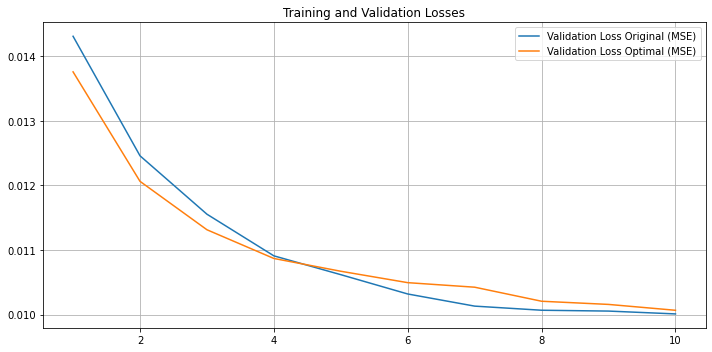

In [35]:
# Check if variable epochs is declared. If not, model was not fitted in this run.
if epochs_:
    epochs_range = range(1, epochs_+1)
    # Training/Validation values from this run.
    train_hist_opt = OptimalModel.history.history
else:
    epochs_range = range(1, 11)
    # Training/Validation values from last run of 10 epochs.
    train_hist_opt = {'loss': 
                     [0.017674410715699196,
                      0.012393511831760406,
                      0.011105840094387531,
                      0.01038892101496458,
                      0.009908482432365417,
                      0.009564503096044064,
                      0.009306768886744976,
                      0.00908990390598774,
                      0.008906392380595207,
                      0.008763973601162434],
                     'val_loss': 
                     [0.013759571127593517,
                      0.012063642032444477,
                      0.011313683353364468,
                      0.010868818499147892,
                      0.01067076064646244,
                      0.010494054295122623,
                      0.010423730127513409,
                      0.010206121951341629,
                      0.010157021693885326,
                      0.010066259652376175]}

    
loss_opt = train_hist_opt['loss']
val_loss_opt = train_hist_opt['val_loss']

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, val_loss, label='Validation Loss Original (MSE)')
plt.plot(epochs_range, val_loss_opt, label='Validation Loss Optimal (MSE)')
plt.legend()
plt.title('Training and Validation Losses');
plt.grid()
plt.tight_layout();

In [36]:
# # To be used if training results are better than those in previous runs.
# reconstructor.save_weights('./checkpoints/Optimal-Param-Model-OrganAMNIST')

## Evaluating The Optimal Model Against the Original

In [37]:
nn_opt_recons = np.empty_like(testXradon, dtype='float')
nn_opt_time = 0

start_nn = time.time()
nn_opt_recons = OptimalModel.predict(testXradon)
end_nn = time.time()
nn_opt_time = end_nn-start_nn

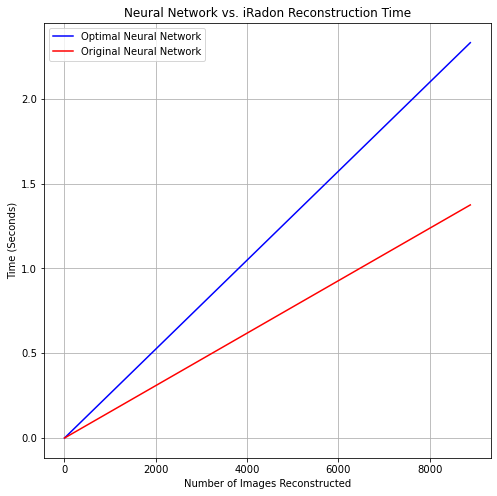

In [38]:
nn_times_list = [i*(nn_time/len(testXfloat)) for i in range(len(testXfloat))]
nn_opt_times_list = [i*(nn_opt_time/len(testXfloat)) for i in range(len(testXfloat))]

plt.figure(figsize=(8, 8))
plt.plot(range(len(testXfloat)), nn_opt_times_list, 'blue', label='Optimal Neural Network')
plt.plot(range(len(testXfloat)), nn_times_list, 'red', label='Original Neural Network')
plt.title('Neural Network vs. iRadon Reconstruction Time')
plt.xlabel('Number of Images Reconstructed')
plt.ylabel('Time (Seconds)')
plt.grid()
plt.legend();

In [39]:
nn_opt_mse_vals = []

for i in range(testXfloat.shape[0]):
    nn_opt_mse_vals.append(np.sqrt(((nn_opt_recons[i] - testXfloat[i]) ** 2).mean()))
    
print('The avgerage MSE for Optimal Neural Network Reconstruction is: ', sum(nn_opt_mse_vals)/testXfloat.shape[0])
print('The avgerage MSE for Original Neural Network Reconstruction is: ', sum(nn_mse_vals)/testXfloat.shape[0])

The avgerage MSE for Optimal Neural Network Reconstruction is:  0.25506550583790943
The avgerage MSE for Original Neural Network Reconstruction is:  0.09722634089292898


In [40]:
print('Meaning, the Original has an MSE that is: ', sum(nn_opt_mse_vals)/sum(nn_mse_vals),
      'times smaller than that of the Optimal, and')
print('the Original is: ', nn_opt_time/nn_time,'times faster than the Optimal.')

Meaning, the Original has an MSE that is:  2.6234197800244448 times smaller than that of the Optimal, and
the Original is:  1.6959462554313993 times faster than the Optimal.


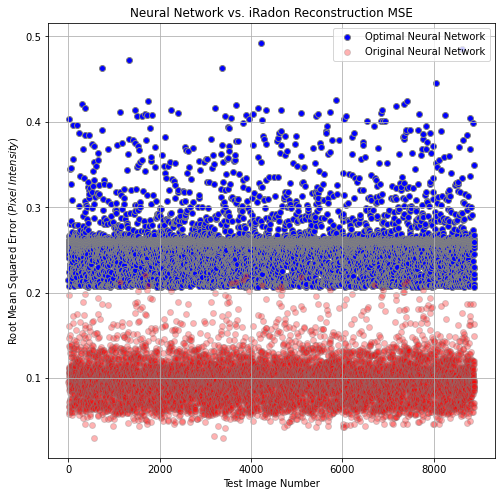

In [41]:
plt.figure(figsize=(8, 8))
plt.scatter(range(len(testXfloat)), nn_opt_mse_vals, edgecolors='gray', 
            color='blue', label='Optimal Neural Network')
plt.scatter(range(len(testXfloat)), nn_mse_vals, alpha=0.3, edgecolors='gray', 
            color='red', label='Original Neural Network')
plt.title('Neural Network vs. iRadon Reconstruction MSE')
plt.xlabel('Test Image Number')
plt.ylabel('Root Mean Squared Error ($Pixel$ $Intensity$)')
plt.grid()
plt.legend();

---

## Visualizing the Optimal Model's Convolution Layers' Outputs

/var/folders/t7/12vt331d17518g8xjkn8hst80000gn/T/ipykernel_980/582392573.py:27: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()


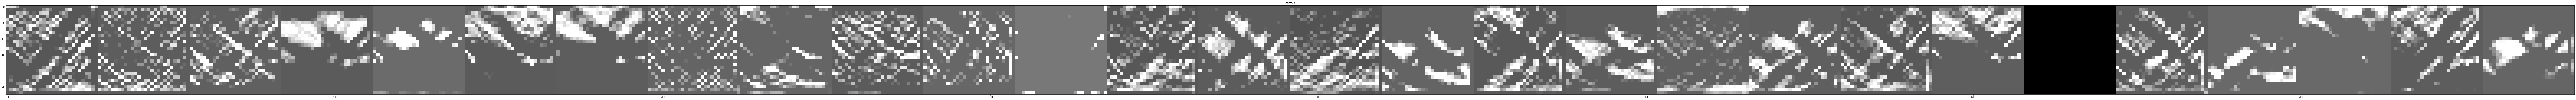

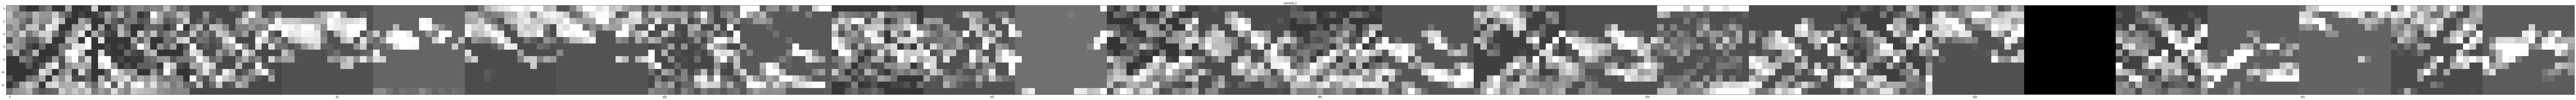

In [42]:
successive_outputs = [layer.output for layer in reconstructor.CNN.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = reconstructor.CNN.input, outputs = successive_outputs)
# Load the input image 
x = testXradon[258]
x = x.reshape((1,) + x.shape) # Rescale by 1/255

# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x) 

# Retrieve are the names of the layers, so can have them as part of our saved images
layer_names = [layer.name for layer in reconstructor.CNN.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:

        # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))

        # Postprocess the feature to be visually palatable
        for i in range(n_features):
            x  = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x  = np.clip(x, 0, 255).astype('uint8')
            # Tile each filter into a horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x      # Display the grid
        scale = 200. / n_features
        if n_features > 10:
            plt.figure( figsize=(scale * n_features, scale) )
            plt.title ( layer_name )
            plt.grid  ( False )
            plt.imshow( display_grid, aspect='auto', cmap='gray')
            plt.savefig('./CNN_Features/Features_'+str(layer_name)+'.png')